In [1]:
# in order to clssify music by their genre, we must transform the data into something a machine can understand
# https://librosa.org/doc/latest/index.html
# https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html
# source music files https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

# READ: ->>>> make sure to connect the shared drive to the resource folders

# since this process takes time, we will be exporting the resulting data to a json file
# so that we can just load that to the next step instead of repeating this step every time.

import librosa
import librosa.display
import json
import os
import math
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# sample rate for sound files, given librosa
sr = 22050  
hop = 512
nfft = 2048
n = 13

# dict for data
dataset = {
    'genre': [],  # label to genre: rock -> 0, folk -> 1 etc..
    'mfcc': [],  # storing the mel data of each track
    'class': []  # actual labels for each mfcc
}


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#data = '/Users/jieunyoo/Downloads/genres_original'
data = '/content/gdrive/Shareddrives/data_IntroML_music_classif/genres_original'
# the json file name should be n_segments.json where n is the number of segments for the dataset
json_dir = '/Users/jieunyoo/MUSIC2/6_segments.json'
track_time = 30
segments = 6

# samples for each segment will be used to crop the tracks into smaller parts
samples_for_segment = int((sr * track_time) / segments)  # sample rate for 30s / segments

In [ ]:
# This will take a while as we have to process all the 1000 music files, 
# split them into segments and retrive mfcc for each. Estimated time 2:30 minutes
# for all files within data
c = 0
for e, (path, folder, file) in enumerate(os.walk(data)):
    # must be in a subfolder
    if path is not data:
        # get the genre from the folder
        c += 1
        collect_genre = path.split('/')[-1] # split the path into two parts, get the name of the folder which indicates the genre of the files it holds
        dataset['genre'].append(collect_genre) # append the genres into the dictionary's list -> we get dataset['genre'] = [rock, metal, pop, jazz etc.]
        print('Working on',collect_genre)
        # go through all the files and collect them
        for song in file:
            # load song to librosa for processing
            path_local = os.path.join(path, song) # add the original path + song name as final path for this file
            signal, sample_rate = librosa.load(path_local, sr=sr) # get signal and sample rate from librosa

            # split the files into smaller segments for more data
            for s in range(segments):
                start = s * samples_for_segment
                end = start + samples_for_segment
                # get mfcc of each segment
                mfcc = librosa.feature.mfcc(signal[start:end], sr=sr, n_fft=nfft, n_mfcc=n, hop_length=hop)
                mfcc = mfcc.T   # reshape

                check = math.ceil(samples_for_segment/hop) # a check flag to insure homogeneus segments
                if len(mfcc) == check:
                    dataset['mfcc'].append(mfcc.tolist()) # collect mfcc data and class label
                    dataset['class'].append(e-1)
                    #print('Type:', collect_genre, 'Segment:', s+1)
    print('Completed:',c,'/10')

In [ ]:
# export to json
# estimated time 1 min
with open(json_dir, 'w') as j:
    json.dump(dataset, j, indent=2)

# Feature extraction
The next type of models need other, hand-crafted,  features  to  be  fed  into  the  machine learning classifiers.  These features represent well enough audio signale. They can be classified  as time  domain  and frequency  domain features.   

### Time domain features

**Zero-Crossing Rate:** A very simple way for measuring the smoothness of a signal is to calculate the number of zero-crossing within a segment of that signal. A voice signal oscillates slowly — for example, 100 zero crossing per second — whereas an unvoiced fricative can have 3000 zero crossings per second.

**Root Mean Square Energy (RMSE):** It represents the energy in a signal
### Frequency domain features

**Spectral Centroid:** For each frame, this corresponds to the frequency around which mostof the energy is centered.

**Spectral Rolloff:** It is a measure of the shape of the signal. It corresponds to the value of frequency below which 85%(usually) of the  total  energy  in  the  spectrum  lies.

**Spectral Bandwidth:**  The spectral bandwidth is defined as the width of the band of light at one-half the peak maximum (or full width at half maximum).

**Mel-FrequencyCepstralCoefficients(MFCC):** The Mel-scale models the human auditory perception and hence is a useful feature to use in such problems. These coefficients are the most widely used timbral audio feature. They  are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.

**Chroma Features:** This  is  a  vector  which corresponds  to  the  total  energy  of  the  sig-nal in each of the 12 pitch classes.  (C,C#,D,D#,E,F,F#,G,G#,A,A#,B) 



### Example plots for a metal song

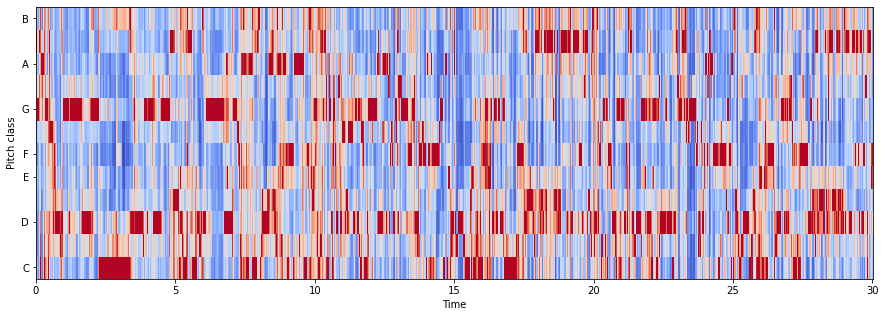

In [ ]:
metal, sr1 = librosa.load('/content/gdrive/Shareddrives/data_IntroML_music_classif/genres_original/metal/metal.00000.wav')
chromagram = librosa.feature.chroma_stft(metal, sr=sr1, hop_length=hop)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop, cmap='coolwarm')

Metal song
Zero crossing count:  19


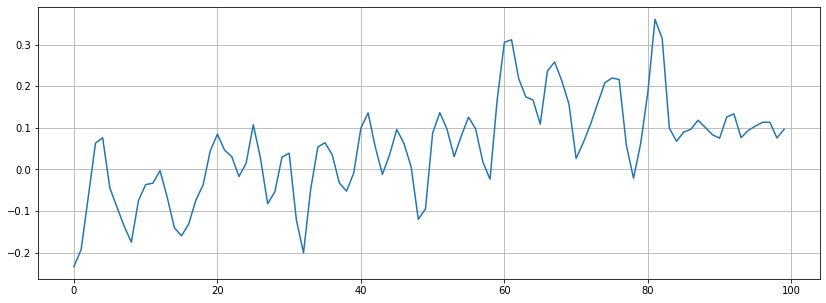

In [ ]:
#plt.figure(figsize=(14, 5))
#librosa.display.waveplot(metal, sr=sr1)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(metal[n0:n1])
plt.grid()

zero_crossings = librosa.zero_crossings(metal[n0:n1], pad=False)
print("Metal song")
print("Zero crossing count: ",sum(zero_crossings))

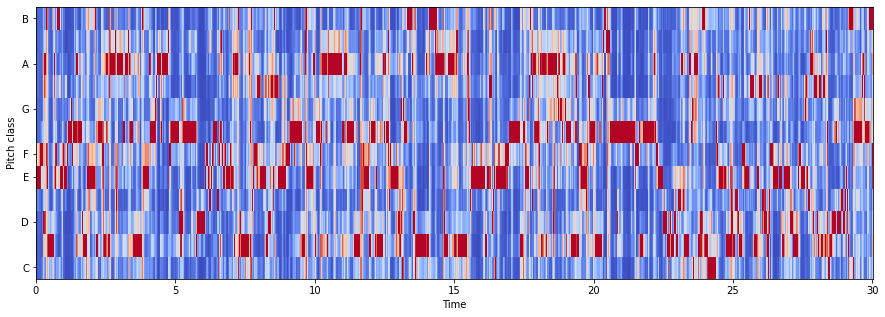

In [ ]:
reggae, sr2 = librosa.load('/content/gdrive/Shareddrives/data_IntroML_music_classif/genres_original/reggae/reggae.00000.wav')
chromagram = librosa.feature.chroma_stft(reggae, sr=sr2, hop_length=hop)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop, cmap='coolwarm')

Reggae song
Zero crossing count:  11


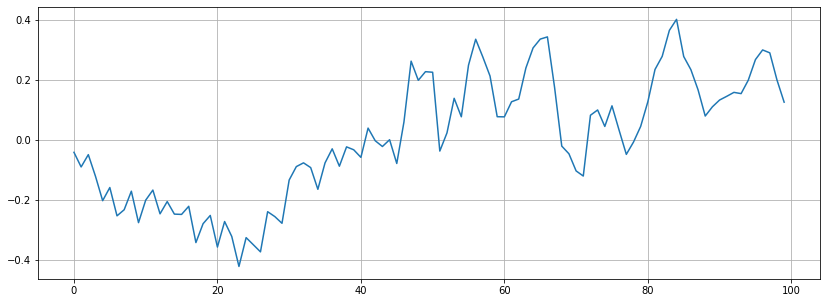

In [ ]:
#plt.figure(figsize=(14, 5))
#librosa.display.waveplot(reggae, sr=sr2)
# Zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(reggae[n0:n1])
plt.grid()

zero_crossings = librosa.zero_crossings(reggae[n0:n1], pad=False)
print("Reggae song")
print("Zero crossing count: ",sum(zero_crossings))

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

file = open('data2.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/Users/jieunyoo/Downloads/genres_original/{g}'):
        songname = f'/Users/jieunyoo/Downloads/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data2.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [10]:
import pandas as pd
data = pd.read_csv('/content/gdrive/Shareddrives/data_IntroML_music_classif/data3.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,hiphop.00002.wav,0.374110,0.096362,1491.814276,1876.680876,3083.833822,0.061209,-200.918045,131.288940,3.104079,41.464176,-9.854139,14.824077,-14.515983,17.883909,-16.739536,7.845377,-9.086815,7.987399,-6.009991,6.549060,-7.337484,3.736610,-7.182334,-1.444591,-2.280662,-4.807340,hiphop
1,hiphop.00002.wav,0.407363,0.096135,1473.294608,1869.547502,2975.619507,0.060773,-198.120590,134.139069,9.802384,41.382099,-16.611473,16.433254,-15.195705,14.787169,-18.018745,7.506089,-7.682391,7.787492,-6.400132,2.765923,-8.370537,4.223436,-6.340567,1.479161,-2.710301,-4.396660,hiphop
2,hiphop.00002.wav,0.442411,0.096869,1526.401441,1966.172273,3170.166016,0.060499,-201.407990,131.461151,21.033974,44.882469,-8.916587,20.489672,-12.879906,12.153151,-20.316257,8.927413,-14.934187,7.584690,-4.600553,-1.272543,-6.072952,-0.477372,-8.501351,1.607714,-1.346183,-1.064731,hiphop
3,hiphop.00002.wav,0.441435,0.099490,1342.303845,1818.037687,2888.589478,0.048087,-186.680481,143.672791,6.338370,45.972931,-7.245102,13.218585,-13.027787,13.190784,-15.345152,11.914101,-17.354593,6.910085,-0.868626,-2.162286,-4.719602,-1.245073,-10.869537,1.102471,-1.571181,-0.996123,hiphop
4,hiphop.00002.wav,0.384115,0.090280,1622.089818,2032.751172,3391.678874,0.062012,-212.903931,124.016075,18.446774,47.526337,-9.455337,22.459122,-14.617706,17.573542,-14.975121,13.039888,-12.204940,8.297913,-5.292953,0.964682,-4.859805,1.502245,-5.369806,0.679275,-3.591228,-2.066020,hiphop


In [11]:
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.374110,0.096362,1491.814276,1876.680876,3083.833822,0.061209,-200.918045,131.288940,3.104079,41.464176,-9.854139,14.824077,-14.515983,17.883909,-16.739536,7.845377,-9.086815,7.987399,-6.009991,6.549060,-7.337484,3.736610,-7.182334,-1.444591,-2.280662,-4.807340,hiphop
1,0.407363,0.096135,1473.294608,1869.547502,2975.619507,0.060773,-198.120590,134.139069,9.802384,41.382099,-16.611473,16.433254,-15.195705,14.787169,-18.018745,7.506089,-7.682391,7.787492,-6.400132,2.765923,-8.370537,4.223436,-6.340567,1.479161,-2.710301,-4.396660,hiphop
2,0.442411,0.096869,1526.401441,1966.172273,3170.166016,0.060499,-201.407990,131.461151,21.033974,44.882469,-8.916587,20.489672,-12.879906,12.153151,-20.316257,8.927413,-14.934187,7.584690,-4.600553,-1.272543,-6.072952,-0.477372,-8.501351,1.607714,-1.346183,-1.064731,hiphop
3,0.441435,0.099490,1342.303845,1818.037687,2888.589478,0.048087,-186.680481,143.672791,6.338370,45.972931,-7.245102,13.218585,-13.027787,13.190784,-15.345152,11.914101,-17.354593,6.910085,-0.868626,-2.162286,-4.719602,-1.245073,-10.869537,1.102471,-1.571181,-0.996123,hiphop
4,0.384115,0.090280,1622.089818,2032.751172,3391.678874,0.062012,-212.903931,124.016075,18.446774,47.526337,-9.455337,22.459122,-14.617706,17.573542,-14.975121,13.039888,-12.204940,8.297913,-5.292953,0.964682,-4.859805,1.502245,-5.369806,0.679275,-3.591228,-2.066020,hiphop


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
#print(y)

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


array([[ 0.19760013,  0.17671525, -0.88706069, ...,  0.28474579,
         0.37913605, -0.8449863 ],
       [-0.92833032, -0.46757519, -1.36020272, ..., -1.70605195,
        -0.45714644, -1.78844254],
       [-0.11177642, -0.78230851,  0.05600313, ...,  0.98591908,
         0.69333977,  0.42823384],
       ...,
       [ 1.57640932,  2.69962003,  1.45816211, ..., -0.0779419 ,
        -0.8954664 , -0.66016185],
       [ 0.26116618,  0.31634996, -0.08882173, ...,  0.33457978,
         0.22949533,  0.87609604],
       [ 0.10408812,  0.37475893,  0.05984361, ..., -0.23567762,
        -0.12996164,  0.61228837]])

In [ ]:
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm

# K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=77):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds, average='micro')
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))
find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25)

Best Value for k: 1
F1-Score: 0.9107589658048373


the best k is 1 with error rate 9%


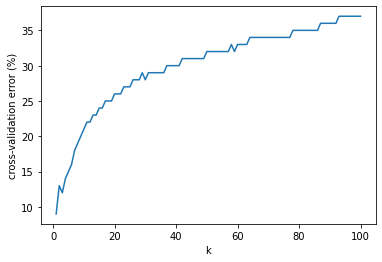

In [ ]:
import numpy as np

def cross_validation(classifier, X, Y, n, *args):

  np.random.seed(1)
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  errors = []
  size = X.shape[0]
  train_sets, val_sets = split_nfold(size, n)
  for (train_index, val_index) in zip(train_sets, val_sets):
    # extract training and validation data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = Y[train_index], Y[val_index]

    # call k-NN classifier
    ypred = classifier(X_val, X_train, y_train, *args)
    errors.append(compute_error_rate(ypred, y_val))
  error_rate = np.mean(errors)
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  return error_rate 



def knn_predict(X_test, X_train, y_train, k):
 
 
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  num_test = X_test.shape[0]
  Y_pred = np.zeros(num_test, dtype=int)
  dists = euclidean_dist(X_test, X_train)
  neighbors = find_k_neighbors(dists, y_train, k)

  for i in range(num_test):
    value, counts = np.unique(neighbors[i], return_counts=True)
    idx = np.argmax(counts)
    Y_pred[i] = value[idx]
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return Y_pred


def split_nfold(num_examples, n):
  """
  """
  # Here is the pseudo code:
 
  
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  idx = np.random.permutation(num_examples).tolist()
  fold_size = num_examples//n
  train_sets = []
  validation_sets = []
  for i in range(n):
      start = i*fold_size
      end = (i+1)*fold_size
      if i == n-1:
        end = num_examples
      train_set = idx[:start] + idx[end:]
      train_sets.append(train_set)
      val_set = idx[start:end]
      validation_sets.append(val_set)
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return train_sets, validation_sets



def euclidean_dist(X_test, X_train):
  dists = np.add(np.sum(X_test ** 2, axis=1, keepdims=True), np.sum(X_train ** 2, axis=1, keepdims=True).T) - 2* X_test @ X_train.T
  return dists


def find_k_neighbors(dists, y_train, k):


  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  num_test = dists.shape[0]
  neighbors = np.zeros((num_test, k))
  sorted_idx = dists.argsort(axis=1)
  for i in range(num_test):
    neighbors[i] = y_train[sorted_idx[i][:k]]
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return neighbors


def compute_error_rate(ypred, ytrue):
 
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  error_rate =  (ypred != ytrue).mean()*100
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return error_rate

list_ks = list(range(1, 101))
num_k = len(list_ks)
err_ks = np.zeros_like(list_ks)
for k in list_ks:
    err_k = cross_validation(knn_predict, X_train, y_train, 10, k)
    err_ks[k-1] = err_k

print(f'the best k is {np.argmin(err_ks)+1} with error rate {min(err_ks)}%')

plt.figure()
plt.plot(list_ks, err_ks)
plt.xlabel('k')
plt.ylabel('cross-validation error (%)')
plt.show()

Best Value for k: 1
F1-Score: 0.8985798609943872


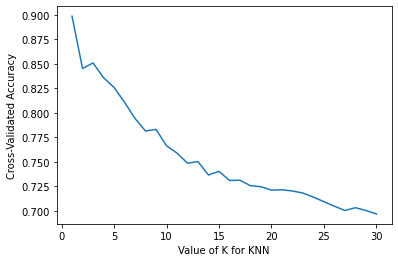

In [ ]:
%matplotlib inline

# choose k between 1 to 31
k_range = range(1, 31)
k_scores = []# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
best_k = 0
best_score = 0.0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1_macro')
    f1 = scores.mean()
    k_scores.append(f1)# plot to see clearly

    if f1 > best_score:
        best_k = k
        best_score = f1

print("Best Value for k: {}".format(best_k))
print("F1-Score: {}".format(best_score))

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

k_range = list(range(1,100))
weight_options = ["uniform", "distance"]

param_grid = dict(n_neighbors = k_range, weights = weight_options)

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.9104945198329855
{'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


In [ ]:
#knn = KNeighborsClassifier(n_neighbors=9)
knn = KNeighborsClassifier(n_neighbors=3)
#i can't run this on google colab for some reason, previous one i forgot
#to change to n_neighbors = 5; so ran again on my computer; got best value = 7

knn.fit(X_train, y_train)
preds = knn.predict(X_test)
from sklearn.metrics import classification_report
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds, average='micro')))
    print("Recall Score: {}".format(recall_score(labels, preds, average='micro')))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds, average='micro')))
    
print_metrics(y_test, preds)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,preds))
print(classification_report(y_test,preds))

    

Precision Score: 0.8949124270225187
Recall Score: 0.8949124270225187
Accuracy Score: 0.8949124270225187
F1 Score: 0.8949124270225187
[[115   1   4   1   0   1   1   0   0   0]
 [  1 106   2   0   0   1   0   0   0   0]
 [  5   2 108   2   1   2   0   1   3   0]
 [  0   0   1 114   0   1   3   1   0   3]
 [  0   1   0   3 107   1   0   2   1   0]
 [  2  11   3   4   0 103   0   0   0   2]
 [  1   0   0   6   0   0 112   0   0   1]
 [  0   0   2   5   2   3   0 109   1   0]
 [  1   0   5   1   4   1   0   2 108   0]
 [  2   1   4   7   1   4   2   0   3  91]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       123
           1       0.87      0.96      0.91       110
           2       0.84      0.87      0.85       124
           3       0.80      0.93      0.86       123
           4       0.93      0.93      0.93       115
           5       0.88      0.82      0.85       125
           6       0.95      0.93      0.94       120
   

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.5521267723102585

              precision    recall  f1-score   support

           0       0.63      0.57      0.60       136
           1       0.89      0.81      0.85       121
           2       0.27      0.42      0.33        80
           3       0.33      0.46      0.39        89
           4       0.46      0.44      0.45       120
           5       0.59      0.62      0.60       120
           6       0.82      0.58      0.68       170
           7       0.83      0.55      0.66       183
           8       0.52      0.51      0.51       124
           9       0.18      0.38      0.25        56

    accuracy                           0.55      1199
   macro avg       0.55      0.53      0.53      1199
weighted avg       0.62      0.55      0.57      1199



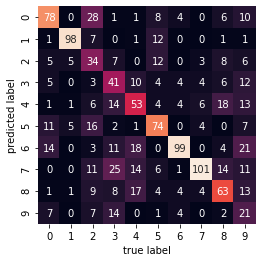

In [ ]:
from sklearn import metrics
import seaborn as sns

forest_predict = forest.predict(X_test)
#pscore = metrics.accuracy_score(y_test, forest_predict)

#pscore
print(metrics.classification_report(forest_predict, y_test))

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, forest_predict)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
del data["label"]
my_list = list(data)
my_list

['chroma_stft',
 'rmse',
 'spectral_centroid',
 'spectral_bandwidth',
 'rolloff',
 'zero_crossing_rate',
 'mfcc1',
 'mfcc2',
 'mfcc3',
 'mfcc4',
 'mfcc5',
 'mfcc6',
 'mfcc7',
 'mfcc8',
 'mfcc9',
 'mfcc10',
 'mfcc11',
 'mfcc12',
 'mfcc13',
 'mfcc14',
 'mfcc15',
 'mfcc16',
 'mfcc17',
 'mfcc18',
 'mfcc19',
 'mfcc20']

No handles with labels found to put in legend.


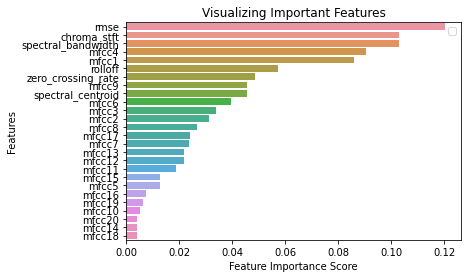

In [ ]:
import seaborn as sns
pred = forest.predict(X_test)
#print(confusion_matrix(y_test, pred))
#print(classification_report(y_test, pred))


feature_imp = pd.Series(forest.feature_importances_, index=my_list).sort_values(ascending=False)
feature_imp

sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# Support Vector Machine

As we have stated before, the problem of classifying audio into mucis genre is a multi-class problem. There are two main approaches when using support vector machines to classify multi-class data. One-vs-one approach in which the model consist in picking two class and then classifies for the given two first. Then, after ascertaining that data doesn’t lie in one class, it builds a classifier for the other versus another class of the classes which was left. The other approach is One-vs-all. In this approach, the model is created for classifying one class versus all the other classes. Thereofre, it classifyes for each class separtely.

In this project we use the later method because it requires less classifiers to train. 

First the hyperparameters for the SVM have to be chosen. For hyperparameter tunning grid search will be used.


In [40]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]},
               {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


#svm_model = GridSearchCV(svm.SVC(C=1), params_grid, cv=5,
#                       scoring='%s_macro' % score)
#svm_model.fit(X_train, y_train)

#print("Best parameters set found on development set:")
#print(clf.best_params_, "\n")

scores = ['accuracy','precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(C=1), params_grid, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_, "\n")


# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C) 
print('Best Kernel:',svm_model.best_estimator_.kernel)
print('Best Gamma:',svm_model.best_estimator_.gamma)


Best parameters set found on development set:
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



In [ ]:
final_model = svm_model.best_estimator_ # With params c: 100 kernel: rbf, gamma: 0.01
Y_pred_svm = final_model.predict(X_test)
# Convert numeric classes into genre of music
Y_pred_svm_label = list(encoder.inverse_transform(Y_pred_svm))

[1 2 0 5 0 7 3 0 5 4 6 1 8 2 1 6 1 0 5 1 1 0 0 2 2 3 7 6 0 5 8 3 4 1 3 1 4
 8 8 3 8 7 3 0 3 3 7 7 8 8 4 6 8 3 5 1 5 2 8 5 3 6 7 9 2 7 1 3 1 4 1 8 5 9
 6 8 1 5 4 9 2 7 4 2 7 2 0 0 0 6 0 7 9 6 3 3 9 9 6 2 6 2 9 3 4 7 0 5 3 0 3
 5 8 7 3 4 7 2 2 7 1 6 3 4 4 7 3 6 8 9 3 9 8 5 8 4 9 2 3 4 3 6 0 2 6 5 7 7
 0 6 1 3 0 8 5 5 2 3 3 2 4 3 9 1 3 5 2 0 9 0 1 0 2 5 2 8 2 5 8 7 3 2 0 0 1
 6 4 6 5 1 3 6 4 2 8 5 1 8 2 6]
['classical', 'country', 'blues', 'jazz', 'blues', 'pop', 'disco', 'blues', 'jazz', 'hiphop', 'metal', 'classical', 'reggae', 'country', 'classical', 'metal', 'classical', 'blues', 'jazz', 'classical', 'classical', 'blues', 'blues', 'country', 'country', 'disco', 'pop', 'metal', 'blues', 'jazz', 'reggae', 'disco', 'hiphop', 'classical', 'disco', 'classical', 'hiphop', 'reggae', 'reggae', 'disco', 'reggae', 'pop', 'disco', 'blues', 'disco', 'disco', 'pop', 'pop', 'reggae', 'reggae', 'hiphop', 'metal', 'reggae', 'disco', 'jazz', 'classical', 'jazz', 'country', 'reggae', 'jazz', 'disco', '

In [ ]:
print(classification_report(y_test,Y_pred_svm))
print("Training set accuracy score for SVM: %f" % final_model.score(X_train, y_train))
print("Testing  set accuracy score for SVM: %f" % final_model.score(X_test, y_test ))

              precision    recall  f1-score   support

           0       0.59      0.72      0.65        18
           1       0.80      1.00      0.89        16
           2       0.71      0.57      0.63        30
           3       0.48      0.61      0.54        23
           4       0.62      0.67      0.65        15
           5       0.75      0.68      0.71        22
           6       0.68      0.87      0.76        15
           7       0.61      0.61      0.61        18
           8       0.65      0.54      0.59        24
           9       0.42      0.26      0.32        19

    accuracy                           0.64       200
   macro avg       0.63      0.65      0.64       200
weighted avg       0.63      0.64      0.63       200

Training set accuracy score for SVM: 0.775970
Testing  set accuracy score for SVM: 0.635000


In [ ]:
samples_for_segment
check = math.ceil(samples_for_segment/hop)
hop

512

In [ ]:
# This will take a while as we have to process all the 1000 music files, 
# split them into segments and retrive mfcc for each. Estimated time 2:30 minutes
# for all files within data

c = 0

header = ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate']
for i in range(1, 21):
    header.append(' mfcc'+str(i))
header.append('label')
#print(header)

file = open('/content/gdrive/Shareddrives/data_IntroML_music_classif/data3.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

for e, (path, folder, file) in enumerate(os.walk(data)):
    # must be in a subfolder
    #print(path)
    if path is not data:
        # get the genre from the folder
        c += 1
        collect_genre = path.split('/')[-1] # split the path into two parts, get the name of the folder which indicates the genre of the files it holds
        #dataset['genre'].append(collect_genre) # append the genres into the dictionary's list -> we get dataset['genre'] = [rock, metal, pop, jazz etc.]
        print('Working on',collect_genre)
        # go through all the files and collect them
        for song in file:
            # load song to librosa for processing
            filename=song
            path_local = os.path.join(path, song) # add the original path + song name as final path for this file
            signal, sample_rate = librosa.load(path_local, sr=sr) # get signal and sample rate from librosa

            # split the files into smaller segments for more data
            for s in range(segments):
                start = s * samples_for_segment
                end = start + samples_for_segment

                # Get features
                # get mfcc of each segment
                #mfcc = librosa.feature.mfcc(signal[start:end], sr=sr, n_fft=nfft, n_mfcc=n, hop_length=hop)
                #mfcc = mfcc.T   # reshape

                rmse = librosa.feature.rms(signal[start:end], hop_length=hop)
                chroma_stft = librosa.feature.chroma_stft(signal[start:end], sr=sr, n_fft=nfft, hop_length=hop)
                spec_cent = librosa.feature.spectral_centroid(signal[start:end], sr=sr, n_fft=nfft, hop_length=hop)
                spec_bw = librosa.feature.spectral_bandwidth(signal[start:end], sr=sr, n_fft=nfft, hop_length=hop)
                rolloff = librosa.feature.spectral_rolloff(signal[start:end], sr=sr, n_fft=nfft, hop_length=hop)
                zcr = librosa.feature.zero_crossing_rate(signal[start:end], hop_length=hop)
                mfcc = librosa.feature.mfcc(signal[start:end], sr=sr, n_fft=nfft, hop_length=hop) 
                #if c%20:
                #  print(mfcc)
                
                check = math.ceil(samples_for_segment/hop) # a check flag to insure homogeneus segments
                if len(mfcc.T) == check:
                  to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'     
                  for e in mfcc:
                      to_append += f' {np.mean(e)}'
                  to_append += f' {collect_genre}'
                  #print(to_append)
                  file = open('/content/gdrive/Shareddrives/data_IntroML_music_classif/data3.csv', 'a', newline='')
                  with file:
                      writer = csv.writer(file)
                      writer.writerow(to_append.split())

                #check = math.ceil(samples_for_segment/hop) # a check flag to insure homogeneus segments
                #if len(mfcc) == check:
                 #   dataset['mfcc'].append(mfcc.tolist()) # collect mfcc data and class label
                  #  dataset['class'].append(e-1)
                    #print('Type:', collect_genre, 'Segment:', s+1)
    print('Completed:',c,'/10')

Completed: 0 /10
Working on hiphop
Completed: 1 /10
Working on blues
Completed: 2 /10
Working on country
Completed: 3 /10
Working on rock
Completed: 4 /10
Working on pop
Completed: 5 /10
Working on metal
Completed: 6 /10
Working on classical
Completed: 7 /10
Working on reggae
Completed: 8 /10
Working on disco
Completed: 9 /10
Working on jazz
Completed: 10 /10


In [4]:
data_ext = pd.read_csv('/content/gdrive/Shareddrives/data_IntroML_music_classif/data3.csv')
data_ext.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,hiphop.00002.wav,0.374110,0.096362,1491.814276,1876.680876,3083.833822,0.061209,-200.918045,131.288940,3.104079,41.464176,-9.854139,14.824077,-14.515983,17.883909,-16.739536,7.845377,-9.086815,7.987399,-6.009991,6.549060,-7.337484,3.736610,-7.182334,-1.444591,-2.280662,-4.807340,hiphop
1,hiphop.00002.wav,0.407363,0.096135,1473.294608,1869.547502,2975.619507,0.060773,-198.120590,134.139069,9.802384,41.382099,-16.611473,16.433254,-15.195705,14.787169,-18.018745,7.506089,-7.682391,7.787492,-6.400132,2.765923,-8.370537,4.223436,-6.340567,1.479161,-2.710301,-4.396660,hiphop
2,hiphop.00002.wav,0.442411,0.096869,1526.401441,1966.172273,3170.166016,0.060499,-201.407990,131.461151,21.033974,44.882469,-8.916587,20.489672,-12.879906,12.153151,-20.316257,8.927413,-14.934187,7.584690,-4.600553,-1.272543,-6.072952,-0.477372,-8.501351,1.607714,-1.346183,-1.064731,hiphop
3,hiphop.00002.wav,0.441435,0.099490,1342.303845,1818.037687,2888.589478,0.048087,-186.680481,143.672791,6.338370,45.972931,-7.245102,13.218585,-13.027787,13.190784,-15.345152,11.914101,-17.354593,6.910085,-0.868626,-2.162286,-4.719602,-1.245073,-10.869537,1.102471,-1.571181,-0.996123,hiphop
4,hiphop.00002.wav,0.384115,0.090280,1622.089818,2032.751172,3391.678874,0.062012,-212.903931,124.016075,18.446774,47.526337,-9.455337,22.459122,-14.617706,17.573542,-14.975121,13.039888,-12.204940,8.297913,-5.292953,0.964682,-4.859805,1.502245,-5.369806,0.679275,-3.591228,-2.066020,hiphop


In [5]:
#Frequency distribution of classes"
train_outcome = pd.crosstab(index=data_ext["label"],  # Make a crosstab
                              columns="count")      # Name the count column

train_outcome.transpose()

label,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
col_0,,,,,,,,,,
count,600,600,599,600,599,594,600,600,600,600


In [6]:
data_ext = data_ext.drop(['filename'],axis=1)
data_ext.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.374110,0.096362,1491.814276,1876.680876,3083.833822,0.061209,-200.918045,131.288940,3.104079,41.464176,-9.854139,14.824077,-14.515983,17.883909,-16.739536,7.845377,-9.086815,7.987399,-6.009991,6.549060,-7.337484,3.736610,-7.182334,-1.444591,-2.280662,-4.807340,hiphop
1,0.407363,0.096135,1473.294608,1869.547502,2975.619507,0.060773,-198.120590,134.139069,9.802384,41.382099,-16.611473,16.433254,-15.195705,14.787169,-18.018745,7.506089,-7.682391,7.787492,-6.400132,2.765923,-8.370537,4.223436,-6.340567,1.479161,-2.710301,-4.396660,hiphop
2,0.442411,0.096869,1526.401441,1966.172273,3170.166016,0.060499,-201.407990,131.461151,21.033974,44.882469,-8.916587,20.489672,-12.879906,12.153151,-20.316257,8.927413,-14.934187,7.584690,-4.600553,-1.272543,-6.072952,-0.477372,-8.501351,1.607714,-1.346183,-1.064731,hiphop
3,0.441435,0.099490,1342.303845,1818.037687,2888.589478,0.048087,-186.680481,143.672791,6.338370,45.972931,-7.245102,13.218585,-13.027787,13.190784,-15.345152,11.914101,-17.354593,6.910085,-0.868626,-2.162286,-4.719602,-1.245073,-10.869537,1.102471,-1.571181,-0.996123,hiphop
4,0.384115,0.090280,1622.089818,2032.751172,3391.678874,0.062012,-212.903931,124.016075,18.446774,47.526337,-9.455337,22.459122,-14.617706,17.573542,-14.975121,13.039888,-12.204940,8.297913,-5.292953,0.964682,-4.859805,1.502245,-5.369806,0.679275,-3.591228,-2.066020,hiphop


In [7]:
genre_list = data_ext.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [9]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data_ext.iloc[:, :-1], dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
a = np.array([[1,2,7], [3,4,8]])
b = [5,6]
c = np.insert(a, a.shape[1], b, axis=1)
print(c)

[[1 2 7 5]
 [3 4 8 6]]


In [36]:
a = np.insert(X, X.shape[1], y, axis=1)
df_red = pd.DataFrame(a[:, [0,1,2,3,4,5,6,9,22, 26]], columns = ['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc4', 'mfcc17', 'label'])

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbae1149f90>,
      dtype=object)

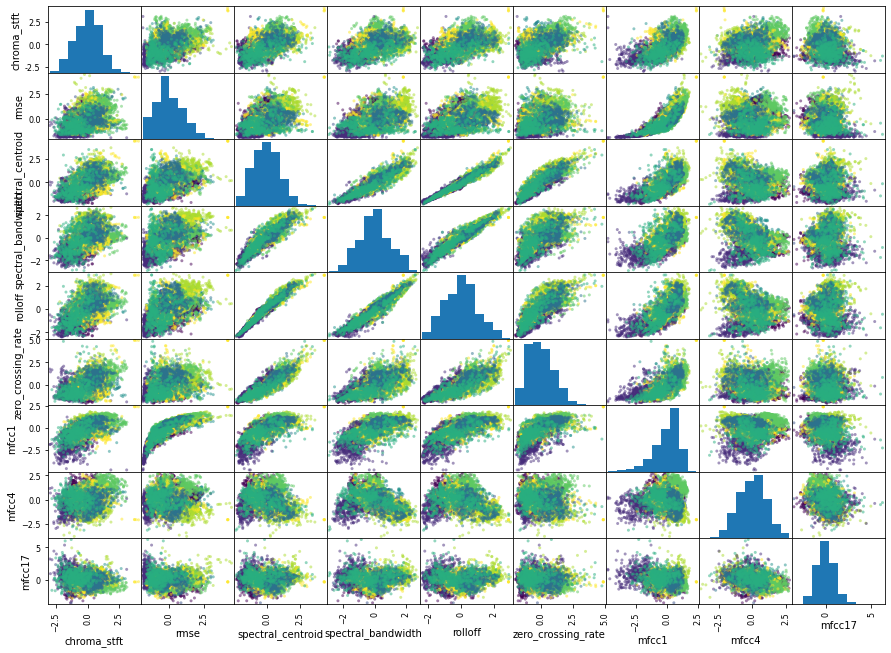

In [38]:
from pandas.plotting import scatter_matrix
import seaborn as sns

colors = df_red['label'].replace({0:1, 1: 2, 2:3, 3:4,4:5,5:6,6:7,7:8,8:9})
scatter_matrix(df_red.iloc[:,0:9], figsize=(15,11), c=colors, cmap='viridis')

In [41]:
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall','accuracy']
'''
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(svm.SVC(C=1), params_grid, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_, "\n")
'''
score="accuracy"
svm_model = GridSearchCV(svm.SVC(C=1), params_grid, cv=5,
                       scoring=score)
svm_model.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(svm_model.best_params_, "\n")

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C) 
print('Best Kernel:',svm_model.best_estimator_.kernel)
print('Best Gamma:',svm_model.best_estimator_.gamma)

Best parameters set found on development set:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'} 

Best C: 1000
Best Kernel: rbf
Best Gamma: 0.001


In [44]:
final_model = svm_model.best_estimator_ # With params {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'} 
Y_pred_svm = final_model.predict(X_test)
# Convert numeric classes into genre of music
Y_pred_svm_label = list(encoder.inverse_transform(Y_pred_svm))

In [ ]:
#final_model = svm_model.best_estimator_ # With params c: 1000 kernel: rbf, gamma: 0.001
final_model = svm.SVC(kernel='rbf', C = 1000, gamma = 0.001)
final_model.fit(X_train, y_train)
Y_pred_svm = final_model.predict(X_test)
# Convert numeric classes into genre of music
Y_pred_svm_label = list(encoder.inverse_transform(Y_pred_svm))

In [43]:
print(classification_report(y_test,Y_pred_svm))
print("Training set accuracy score for SVM: %f" % final_model.score(X_train, y_train))
print("Testing  set accuracy score for SVM: %f" % final_model.score(X_test, y_test ))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81       117
           1       0.91      0.91      0.91       120
           2       0.70      0.75      0.73       124
           3       0.67      0.71      0.69       114
           4       0.84      0.77      0.80       127
           5       0.79      0.83      0.81       108
           6       0.87      0.90      0.88       114
           7       0.89      0.87      0.88       126
           8       0.77      0.75      0.76       125
           9       0.76      0.63      0.69       124

    accuracy                           0.80      1199
   macro avg       0.80      0.80      0.80      1199
weighted avg       0.80      0.80      0.80      1199

Training set accuracy score for SVM: 0.849990
Testing  set accuracy score for SVM: 0.796497


### SVM with reduced data frame to the most important features (from trees)

In [46]:
X_res = X[:, [0,1,2,3,4,5,6,9,22]]
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y, test_size=0.2)

In [47]:
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall','accuracy']
score="accuracy"
svm_model_res = GridSearchCV(svm.SVC(C=1), params_grid, cv=5,
                       scoring=score)
svm_model_res.fit(X_train_res, y_train_res)

print("Best parameters set found on development set:")
print(svm_model_res.best_params_, "\n")

# View the best parameters for the model found using grid search
print('Best C:',svm_model_res.best_estimator_.C) 
print('Best Kernel:',svm_model_res.best_estimator_.kernel)
print('Best Gamma:',svm_model_res.best_estimator_.gamma)

Best parameters set found on development set:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'} 

Best C: 1000
Best Kernel: rbf
Best Gamma: 0.001


In [48]:
final_model_res = svm_model_res.best_estimator_ # With params {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'} 
Y_pred_svm_res = final_model_res.predict(X_test_res)
# Convert numeric classes into genre of music
Y_pred_svm_label_res = list(encoder.inverse_transform(Y_pred_svm_res))

In [49]:
print(classification_report(y_test_res,Y_pred_svm_res))
print("Training set accuracy score for SVM: %f" % final_model_res.score(X_train_res, y_train_res))
print("Testing  set accuracy score for SVM: %f" % final_model_res.score(X_test_res, y_test_res))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63       121
           1       0.84      0.92      0.87       118
           2       0.40      0.44      0.42       105
           3       0.49      0.57      0.53       107
           4       0.59      0.59      0.59       115
           5       0.66      0.70      0.68       132
           6       0.77      0.88      0.82       121
           7       0.84      0.75      0.79       138
           8       0.54      0.49      0.51       109
           9       0.46      0.32      0.37       133

    accuracy                           0.63      1199
   macro avg       0.62      0.63      0.62      1199
weighted avg       0.63      0.63      0.63      1199

Training set accuracy score for SVM: 0.625496
Testing  set accuracy score for SVM: 0.632193


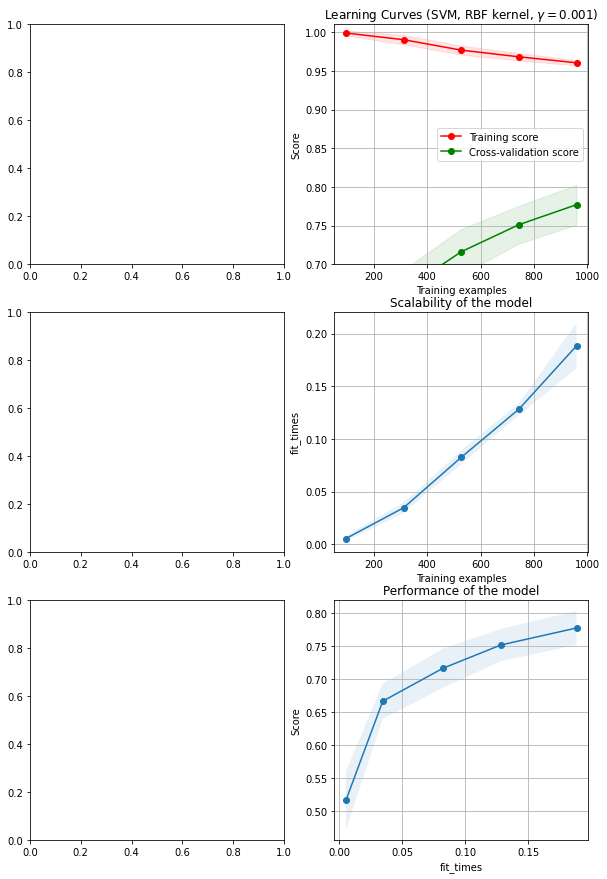

In [ ]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(final_model, title, X_test, Y_pred_svm, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()